In [1]:
!pip install -q datasets
!pip install -q transformers
!pip install -q tensorflow
!pip install -q pandas
!pip install -q numpy

In [2]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer,DataCollatorForTokenClassification, TFAutoModelForTokenClassification, TFAutoModel
import pandas as pd
import numpy as np
from datasets import load_metric
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.math import argmax
from tensorflow import map_fn
import tensorflow as tf
from transformers import pipeline
from transformers import logging

In [3]:
data = pd.read_csv('anotated.csv')

In [4]:
def entity_to_class_label(entity):
    string_to_label = {
        "CORE": 0,
        "HARDWARE": 1,
        "SOFTWARE": 2,
        "USER": 3,
        "VERB": 4
    }
    label = string_to_label.get(entity)
    if label is not None:
        return label
    else:
        return 0

In [5]:
data['class']=data['classification'].apply(entity_to_class_label)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['entities'],data['class'], stratify=data['class'], test_size=0.2)

In [7]:
print(y_train)

2327    1
1430    0
68      3
1164    2
1853    2
       ..
1758    2
1171    2
2384    1
1336    4
211     4
Name: class, Length: 1971, dtype: int64


In [8]:
checkpoint = 'bert-base-cased'
model = TFAutoModel.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

In [9]:
tdf = pd.DataFrame({"ner_tags": y_train, "tokens": X_train })
vdf = pd.DataFrame({"ner_tags": y_test, "tokens": X_test})
tds = Dataset.from_pandas(tdf)
vds = Dataset.from_pandas(vdf)

dataset_dict = DatasetDict()

dataset_dict['train'] = tds
dataset_dict['test'] = vds

In [10]:
# tokenize input dan target
def tokenize_fn(batch):
  return tokenizer(batch["tokens"], padding=True, truncation=True)

In [11]:
dataset_encoded = dataset_dict.map(tokenize_fn, batched=True, batch_size=None)

Map:   0%|          | 0/1971 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

In [12]:
dataset_encoded.set_format('tf',
                            columns=['input_ids', 'attention_mask', 'token_type_ids', 'ner_tags'])

# setting BATCH_SIZE to 64.
BATCH_SIZE = 64

def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(dataset_encoded['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(dataset_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset

In [24]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.pool = tf.keras.layers.GlobalMaxPool1D()

    def call(self, inputs):
        x = self.bert(inputs)
        x = self.dropout(x["last_hidden_state"])
        x = self.pool(x)
        return self.fc(x)

In [25]:

# class BERTForClassification(tf.keras.Model):

#     def __init__(self, bert_model, num_classes):
#         super().__init__()
#         self.bert = bert_model
#         self.conv = tf.keras.layers.Conv1D(256, (2), activation='relu')
#         self.conv2 = tf.keras.layers.Conv1D(128, (2), activation='relu')
#         self.pool = tf.keras.layers.GlobalMaxPool1D()
#         self.dense = tf.keras.layers.Dense(512, activation="relu")
#         self.dropout = tf.keras.layers.Dropout(0.1)
#         self.fc = tf.keras.layers.Dense(num_classes, activation="softmax", name='classifier')

#     def call(self, inputs):
#         x = self.bert(inputs)
#         x = self.dropout(x["last_hidden_state"])
#         x = self.conv(x)
#         x = self.conv2(x)
#         x = self.pool(x)
#         # x = self.dense(x)
#         x = self.dropout(x)
#         return self.fc(x)

In [26]:
classifier = BERTForClassification(model, num_classes=5)
# nan muncul karena pembagi 0
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [27]:
# tambahin train dataset & test dataset
history = classifier.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15


31/31 [==============================] - 126s 538ms/step - loss: 1.4829 - accuracy: 0.3628 - val_loss: 1.3196 - val_accuracy: 0.4097
Epoch 2/15
31/31 [==============================] - 7s 240ms/step - loss: 1.1437 - accuracy: 0.5398 - val_loss: 1.1111 - val_accuracy: 0.5538
Epoch 3/15
31/31 [==============================] - 7s 238ms/step - loss: 0.8059 - accuracy: 0.6981 - val_loss: 0.9757 - val_accuracy: 0.6004
Epoch 4/15
31/31 [==============================] - 8s 246ms/step - loss: 0.5405 - accuracy: 0.8184 - val_loss: 0.9627 - val_accuracy: 0.6227
Epoch 5/15
31/31 [==============================] - 8s 246ms/step - loss: 0.3548 - accuracy: 0.8980 - val_loss: 0.9711 - val_accuracy: 0.6126
Epoch 6/15
31/31 [==============================] - 7s 240ms/step - loss: 0.2038 - accuracy: 0.9589 - val_loss: 1.0317 - val_accuracy: 0.6207
Epoch 7/15
31/31 [==============================] - 8s 250ms/step - loss: 0.1059 - accuracy: 0.9914 - val_loss: 1.1339 - val_accuracy: 0.6247
Epoch 8/15
31/3

In [28]:
classifier.evaluate(test_dataset)

8/8 [==============================] - 1s 71ms/step - loss: 1.6556 - accuracy: 0.6187


[1.6555931568145752, 0.6186612844467163]

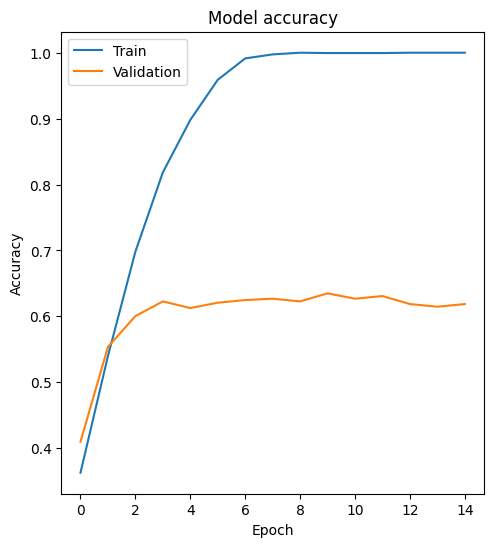

In [29]:
import matplotlib.pyplot as plt
# Plot the learning curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [30]:
def label_to_entity(label):
    label_to_string = {
        0: "CORE",
        1: "HARDWARE",
        2: "SOFTWARE",
        3: "USER",
        4: "VERB"
    }
    entity = label_to_string.get(label)
    if entity is not None:
        return entity
    else:
        return "CORE"

In [31]:
def predict_entity(text):
  input_tokens = tokenizer(text, padding=True, truncation=True)

  input_ids = input_tokens['input_ids']
  attention_mask = input_tokens['attention_mask']
  token_type_ids = input_tokens['token_type_ids']
  #last_hidden_state = input_tokens['last_hidden_state']

  #last_hidden_state = tf.convert_to_tensor(input_tokens['last_hidden_state'])
  input_ids = tf.convert_to_tensor([input_ids])
  attention_mask = tf.convert_to_tensor([attention_mask])
  token_type_ids = tf.convert_to_tensor([token_type_ids])

  predictions = classifier.predict([input_ids, attention_mask, token_type_ids])

  predicted_class = np.argmax(predictions, axis=-1)[0]
  return predicted_class

In [32]:
predict_entity("systems")

1/1 [==============================] - 8s 8s/step


1

In [33]:
Y_pred = X_test.apply(predict_entity)

1/1 [==============================] - 0s 51ms/step


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, Y_pred)

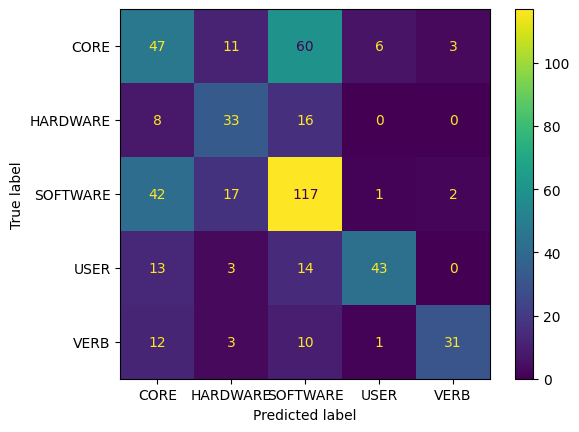

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay


target_names = ['CORE', 'HARDWARE', 'SOFTWARE', 'USER', 'VERB']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)  # Optional: Set display labels
disp.plot(cmap='viridis')  # Colormap for the confusion matrix
plt.show()

In [36]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

precision_macro = precision_score(y_test, Y_pred, average='macro')
accuracy = accuracy_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred, average='macro')
f1_macro = f1_score(y_test, Y_pred, average='macro')


overall_metrics = pd.DataFrame({
    'precision': [precision_macro],
    'recall': [recall],
    'f1': [f1_macro],
    'accuracy': [accuracy],
  })
overall_metrics


,precision,recall,f1,accuracy
0,0.62424,0.547112,0.572178,0.549696
